# Tabular Modeling

This notebook is based on fastai's **[Chapter 9](https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb)**.

Please read that chapter before looking at this review.

*I suggest opening this notebook in Colab (where it can be easier to use GPU).*
*If you want to run it locally, set up the **deep-learning** environment in your terminal with `conda env create -f environment.yml` and activate it in your preferred IDE.*

In [ ]:
### FOR COLAB USERS ###
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [ ]:
# ### FOR LOCAL USERS ###
# import fastai
# print(fastai.__version__)

# ! pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
# import fastbook
# fastbook.setup_book()

In [ ]:
# ! pip install kaggle
# ! pip install treeinterpreter
# ! pip install waterfallcharts

# ! pip install dtreeviz --upgrade
# print(sys.executable)
# ! /usr/bin/python3 -m pip install kaggle dtreeviz

In [ ]:
import sys, os, warnings
if 'google.colab' in sys.modules:
  ! pip install -q dtreeviz

import dtreeviz

In [ ]:
from fastbook import *
from fastai.tabular.all import *

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from IPython.display import Image, display_svg, SVG

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

warnings.simplefilter('ignore', FutureWarning)

# sys.path.append(f"{os.getcwd()}/../")
os.getcwd()

'/content'

# Data
- Tabular data = data in the form of a table (e.g., csv)
- Objective: predict the value in one column based on the values in the other columns

In [ ]:
# data is from kaggle -- set up creds
creds = '{"username":"FILL IN","key":"FILL IN"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()

if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write_text(creds)
  cred_path.chmod(0o600)

cred_path

Path('/root/.kaggle/kaggle.json')

In [ ]:
path = Path('/content/bluebook-for-bulldozers/')
comp = 'bluebook-for-bulldozers'

from kaggle import api
if not path.exists():
  path.mkdir(parents=True)
  api.competition_download_cli(comp, path=path)
  shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

(#7) [Path('/content/bluebook-for-bulldozers/median_benchmark.csv'),Path('/content/bluebook-for-bulldozers/random_forest_benchmark_test.csv'),Path('/content/bluebook-for-bulldozers/ValidSolution.csv'),Path('/content/bluebook-for-bulldozers/TrainAndValid.csv'),Path('/content/bluebook-for-bulldozers/Test.csv'),Path('/content/bluebook-for-bulldozers/Machine_Appendix.csv'),Path('/content/bluebook-for-bulldozers/Valid.csv')]

In [ ]:
# get df
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

# Preprocessing

### Set categories for ordinal column

In [ ]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

### Transform DV
Log the DV because Kaggle wants us to use RMSLE (root mean squared log error) as the evaluation metric

In [ ]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

### Dates

In [ ]:
# note: time series
df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce')
df['saledate'].min(), df['saledate'].max()

(Timestamp('1989-01-17 00:00:00'), Timestamp('2012-04-28 00:00:00'))

In [ ]:
# dates -- add lots of new columns based on 'saledate' column
df = add_datepart(df, 'saledate')

' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [ ]:
# same with test set
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

### Train / Validation Split

In [ ]:
# time series -- training set before Nov 2011, validation after Nov 2011
cond = (df.saleYear<2011) | ((df.saleYear == 2011) & (df.saleMonth<11))
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

# where to split train/validation sets from the df
splits = (list(train_idx),list(valid_idx))

### Create a TabularPandas object
- TabularProc is like a transform step
- Categorify: replaces a column with a numeric categorical column
- FillMissing replaces missing values with the median of the column, and creates a new Boolean column that is set to True for any row where the value was missing
- Result = TabularPandas object (like a Datasets object)


In [ ]:
# tell pandas which columns are categorical and which are continuous
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [ ]:
# create procedures you want (categorify, fill missing data)
procs = [Categorify, FillMissing]

In [ ]:
# actually preprocess the data
to = TabularPandas(
  df,
  procs, # preprocessing
  cat, # categorical var (from above) -- could also put in a list of cols (or blank list)
  cont, # continuous var (from above) -- could also put in a list of cols (or blank list)
  y_names=dep_var, # dv
  splits=splits # train / valid split (from above)
)

len(to.train),len(to.valid)

(395371, 17327)

In [ ]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


#### An example of categorical preprocessing with fewer columns

In [ ]:
to1 = TabularPandas(
  df,
  procs, # preprocessing
  ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], # categorical var
  [], # continuous var
  y_names=dep_var, # dv
  splits=splits # train / valid split
)

In [ ]:
# in the tabularpandas object, you can see the category names...
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [ ]:
# ...but the way the categories are stored is as group numbers
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [ ]:
# show that the underlying columns are still numeric
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [ ]:
# show the classes of ordinal and categorical data
print(to.classes['ProductSize']) # we defined the order of these categories above
print(to.classes['state']) # random ordering

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']
['#na#', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont', 'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin', 'Wyoming']


### Save data

In [ ]:
# save data
save_pickle(path/'to.pkl',to)

In [ ]:
# read in data
d = (path/'to.pkl')

# Decision Trees
Create baseline model(s)

### Model 1

In [ ]:
# train/validation sets (take the labels for this we gave to tabularpandas earlier)
xs, valid_xs = to.train.xs, to.valid.xs
y, valid_y = to.train.y, to.valid.y

print(valid_y[:3])
valid_xs.head(3)

23216    10.714417
23217     9.615806
23218     9.210340
Name: SalePrice, dtype: float32


,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,...,saleDay,saleDayofweek,saleDayofyear,saleElapsed
23216,2,157,40,59,...,4,4,308,1.320365e+09
23217,1,4924,1885,0,...,3,3,307,1.320278e+09
23218,2,4035,1424,159,...,3,3,307,1.320278e+09


In [ ]:
# create tree -- set max leaf nodes (the bottom layer) to be 4
max_leaf_nodes=4
m = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes)
m.fit(xs.values, y.values);

In [ ]:
# define evaluation metric -- root mean squared error
def r_mse(pred,y): # math for rmse
  return round(math.sqrt(((pred-y)**2).mean()), 6)

def m_rmse(m, xs, y): # get the rmse for the sample
  return r_mse(m.predict(xs), y)

In [ ]:
# evaluate on training and validation sets
print("rmse for training set:", m_rmse(m, xs.values, y.values))
print("rmse for validation set:", m_rmse(m, valid_xs.values, valid_y.values))

rmse for training set: 0.552559
rmse for validation set: 0.570385


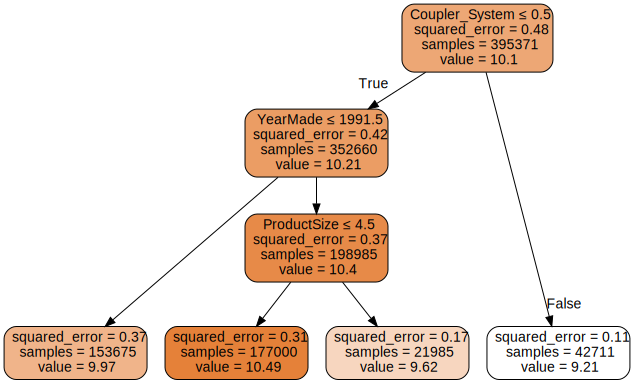

In [ ]:
# see where splits were made
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

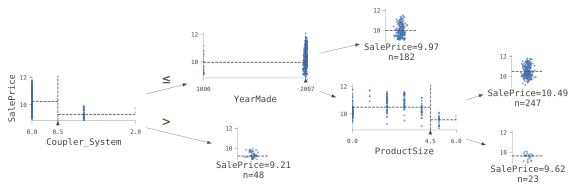

In [ ]:
# same info, different graph
samp_idx = np.random.permutation(len(y))[:500]

viz = dtreeviz.model(
  model=m,
  X_train=xs.iloc[samp_idx],
  y_train=y.iloc[samp_idx],
  feature_names=xs.columns.tolist(),
  target_name=dep_var,
)

viz.view(orientation="LR", fontname="monospace")

#### Recode the year that is "1000"
Probably miscoded

In [ ]:
# recode the year value that is 1000 (probably miscoded)
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

In [ ]:
# same decision tree model
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs.values, y.values)

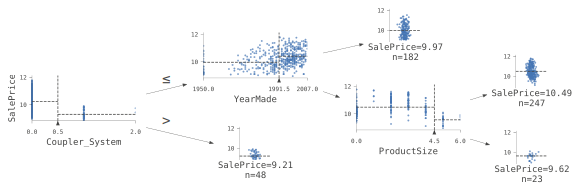

In [ ]:
# visualize
viz = dtreeviz.model(
  model=m,
  X_train=xs.iloc[samp_idx],
  y_train=y.iloc[samp_idx],
  feature_names=xs.columns,
  target_name=dep_var,
)
viz.view(orientation="LR", fontname="monospace")

### Model 2

In [ ]:
# don't pass any stopping criteria (e.g., max_leaf_nodes)
m = DecisionTreeRegressor()
m.fit(xs, y);

In [ ]:
# metrics on training/validation
# overfitting a lot!
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.0, 0.366214)

In [ ]:
# examine why we are overfitting
# too many leaves. almost one per data point
m.get_n_leaves(), len(xs)

(317425, 395371)

### Model 3

In [ ]:
# make sure each leaf node has at least 25 values
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)

DecisionTreeRegressor(min_samples_leaf=25)

In [ ]:
# metrics on training/validation
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.241408, 0.339044)

In [ ]:
# much better
m.get_n_leaves()

12098

# Random Forest
- Ensembles of decision trees are our first approach for analyzing a new tabular dataset.
- The exception to this guideline is when the dataset meets one of these conditions:
  1. There are some high-cardinality categorical variables that are very important ("cardinality" refers to the number of discrete levels representing categories, so a high-cardinality categorical variable is something like a zip code, which can take on thousands of possible levels).
  2. There are some columns that contain data that would be best understood with a neural network, such as plain text data.
- In practice, when we deal with datasets that meet these exceptional conditions, we always try both decision tree ensembles and deep learning to see which works best.

Note:
- It is possible to use one-hot encoding to replace a single categorical variable with multiple one-hot-encoded columns, where each column represents a possible level of the variable. Pandas has a get_dummies method which does just that. However, there is not really any evidence that such an approach improves the end result. So, we generally avoid it where possible, because it does end up making your dataset harder to work with.

## Model 1

### Train model

In [ ]:
def rf(
  xs,
  y,
  n_estimators=40, # how many trees should be in the forest
  max_samples=200_000, # how we should subset the data items (the rows)
  max_features=0.5, # and how we should subset the fields (the columns) -- 0.5 means "half" the cols
  min_samples_leaf=5, # depth of tree: when to stop splitting the tree nodes
  **kwargs # e.g., n_jobs = build trees in parallel
):

  m = RandomForestRegressor(
    n_jobs=-1, # use all our CPUs to build the trees in parallel
    n_estimators=n_estimators,
    max_samples=max_samples, max_features=max_features,
    min_samples_leaf=min_samples_leaf, oob_score=True
  ).fit(xs, y)
  return m

In [ ]:
# fit model
m = rf(xs.values, y.values);

### Evaluate w RMSE

In [ ]:
# rmse for training set and validation set
m_rmse(m, xs.values, y.values), m_rmse(m, valid_xs.values, valid_y.values)

(0.170392, 0.245037)

In [ ]:
# for the validation set
# get the predictions from each individual tree in our forest (estimators_)
valid_preds = np.stack([t.predict(valid_xs.values) for t in m.estimators_]);

In [ ]:
# average rmse (same as fit metric above)
print(r_mse(valid_preds.mean(0), valid_y))

0.245037


In [ ]:
# SD of preds over all the trees in the valididation set
preds_std = valid_preds.std(0)
print(preds_std)

[0.23789277 0.23639787 0.22411932 ... 0.15059599 0.23926614 0.28974235]


In [ ]:
# SD for the predictions of the first 5 rows
  # For some rows, there is a low standard deviation because the trees agree.
  # For others it's higher, as the trees don't agree.
preds_std[:5]

array([0.23789277, 0.23639787, 0.22411932, 0.17637419, 0.21454853])

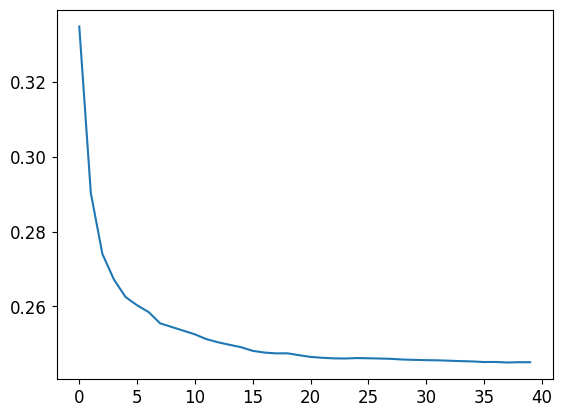

In [ ]:
# plot how the rmse changes when you add more trees (1 tree, 2 trees, etc.)
# improvement levels off around 30 trees
plt.plot([r_mse(valid_preds[:i+1].mean(0), valid_y) for i in range(40)]);

### Out of Bag Error
- Recall that in a random forest, each tree is trained on a different subset of the training data. The OOB error is a way of measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was not included in training. This allows us to see whether the model is overfitting, without needing a separate validation set.using the training set
- Since every tree was trained with a different randomly selected subset of rows, out-of-bag error is a little like imagining that every tree therefore also has its own validation set. That validation set is simply the rows that were not selected for that tree's training.
- This is particularly beneficial in cases where we have only a small amount of training data, as it allows us to see whether our model generalizes without removing items to create a validation set.
- Helps you compare models

In [ ]:
# out of bag score (same as R^2)
m.oob_score_

0.9073354459776558

In [ ]:
# rmse of the out of bag predictions compared to the true values
# since this is low, it means that the problem with the validation set is NOT overfitting -- it's something else
r_mse(m.oob_prediction_, y)

0.210948

### Feature Importance

In [ ]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [ ]:
# show top 10 features
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.176113
6,ProductSize,0.113281
30,Coupler_System,0.100286
7,fiProductClassDesc,0.072454
31,Grouser_Tracks,0.059743
54,ModelID,0.057580
65,saleElapsed,0.050803
3,fiSecondaryDesc,0.042554
12,Enclosure,0.037624
32,Hydraulics_Flow,0.037428


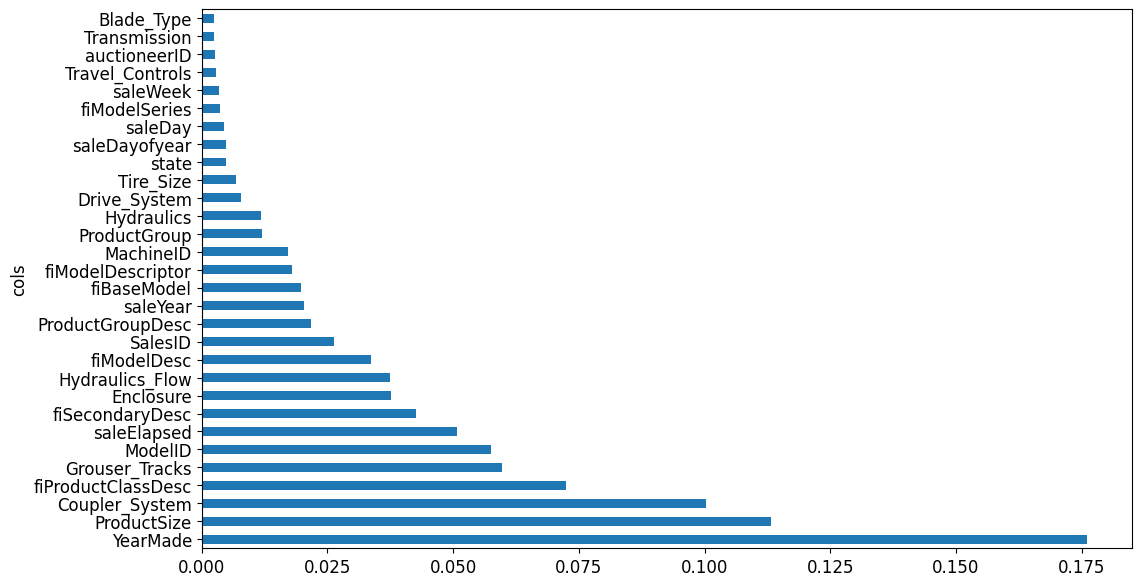

In [ ]:
# plot
plot_fi(fi[:30]);

## Model 2

In [ ]:
# remove columns with low feature importance
to_keep = fi[fi.imp>0.005].cols
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
len(xs.columns), len(xs_imp.columns)

(66, 21)

In [ ]:
# retrain model
m = rf(xs_imp, y)

In [ ]:
# mean rmse for training and validation sets
print(m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y))

0.180432 0.244199


In [ ]:
# out of bag score (same as R^2)
m.oob_score_

0.9050294737946911

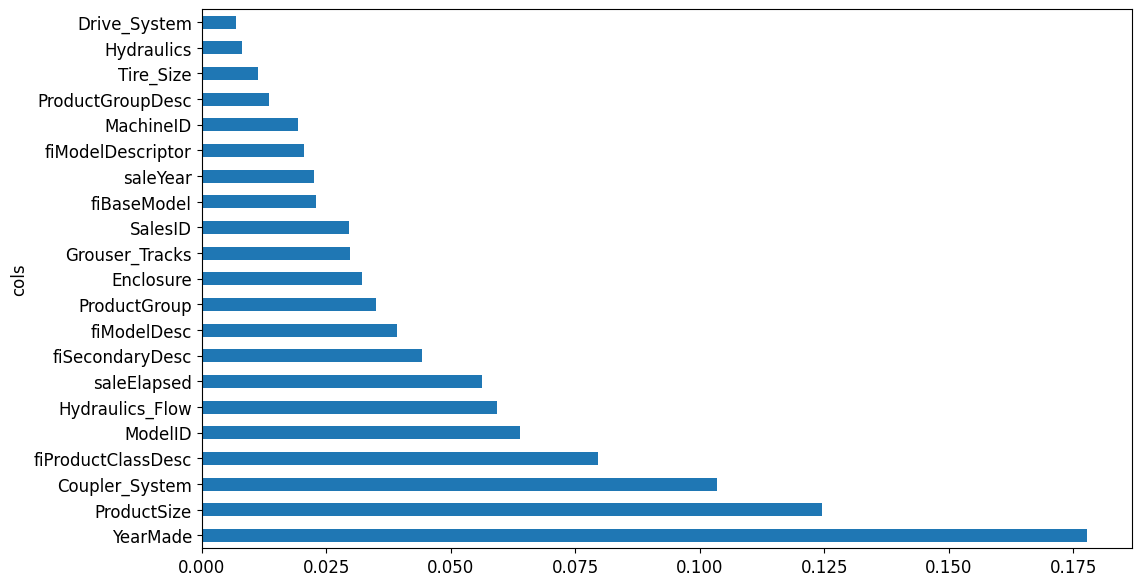

In [ ]:
# feature importance
plot_fi(rf_feat_importance(m, xs_imp));

## Model 3

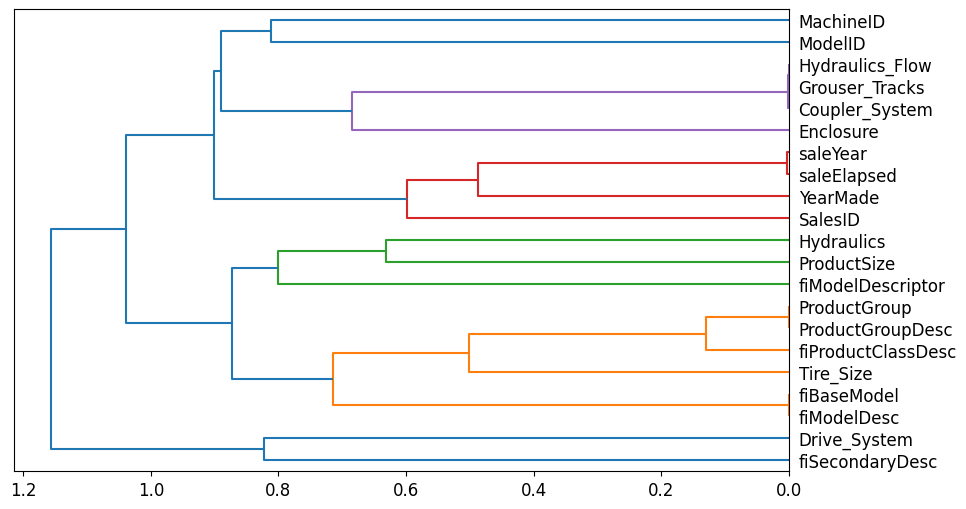

In [ ]:
# remove redundant features
# the pairs of columns that are most similar are the ones that were merged together early (closer to the right),
# far from the "root" of the tree at the left.
cluster_columns(xs_imp)

In [ ]:
# function to get out-of-bag error (same as R^2!)
# note the hyperparams are different than before
def get_oob(df):
  m = RandomForestRegressor(
    n_estimators=40, min_samples_leaf=15,
    max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True
  )
  m.fit(df, y)
  return m.oob_score_ # R^2!

In [ ]:
# baseline
get_oob(xs_imp)

0.8776325563550444

In [ ]:
# remove one column at a time -- get oob error
{
  c:get_oob(xs_imp.drop(c, axis=1)) for c in (
  'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
  'fiModelDesc', 'fiBaseModel',
  'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System'
  )
}

{'saleYear': 0.8763000711030566,
 'saleElapsed': 0.872739672168388,
 'ProductGroupDesc': 0.877661112998979,
 'ProductGroup': 0.8772460346019089,
 'fiModelDesc': 0.8759039361096587,
 'fiBaseModel': 0.8762171859698746,
 'Hydraulics_Flow': 0.8777607341532373,
 'Grouser_Tracks': 0.8782020648427099,
 'Coupler_System': 0.8776374578020985}

In [ ]:
# drop multiple at a time -- get oob error
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8741539763668594

In [ ]:
# confirm the rmse and save this model
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.1824, 0.246579)

In [ ]:
# # if want to load these later
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

xs_final_tmp = load_pickle(path/'xs_final.pkl')
valid_xs_final_tmp = load_pickle(path/'valid_xs_final.pkl')

### Partial dependence
- Understand the relationship between the two most important predictors (product size and year made) with the DV (sale price)
- Partial dependence plots try to answer the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable?
- For instance, how does YearMade impact sale price, all other things being equal?
- Replace every single value in the YearMade column with 1950, and then calculate the predicted sale price for every auction, and take the average over all auctions. Then we do the same for 1951, 1952, and so forth until our final year of 2011. This isolates the effect of only YearMade

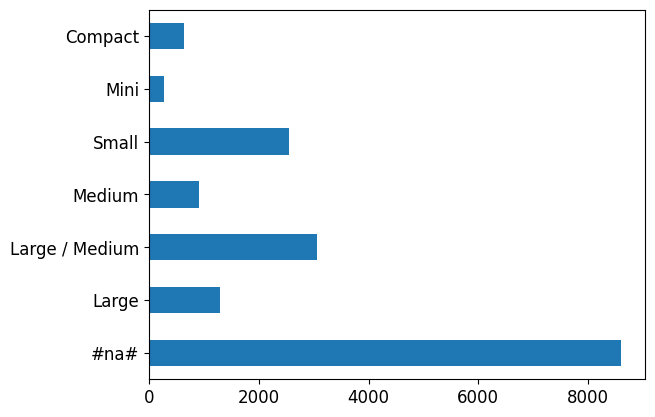

In [ ]:
# product size: check value counts per category
# this plot disagrees with the book -- can't figure out why!!!
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

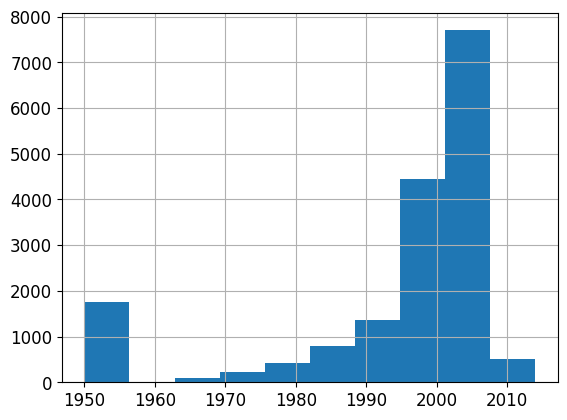

In [ ]:
# year made: check value counts per category
# linear relationship over time (but we took the log of the value, so really it is expontential!)
ax = valid_xs_final['YearMade'].hist()

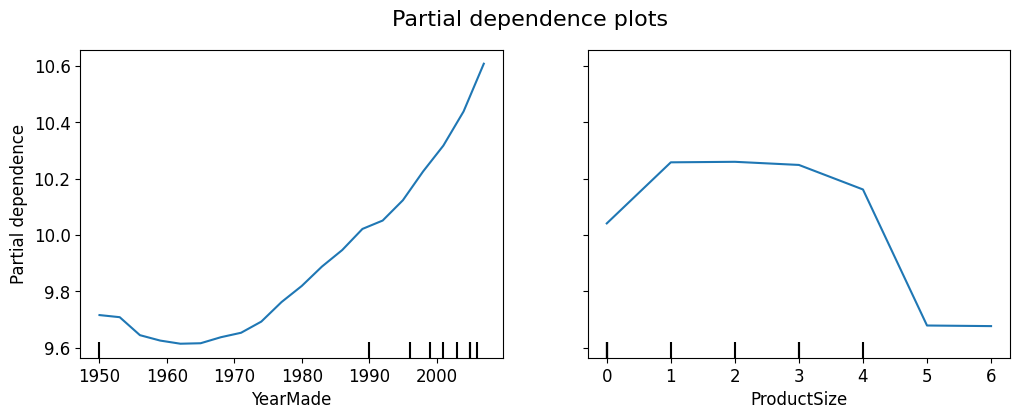

In [ ]:
# partial dependence plot
# plot each year (or product size) on the x-axis, and each of the predictions on the y-axis

features_info = {
 "features":['YearMade','ProductSize'],
 "kind":"average", # kind of partial dependence plot
 #"categorical_features":[list of cat features]
}

common_params = {
  "grid_resolution":20,
  #"subsample":50,
  #"n_jobs":2,
  #"random_state":123,
}

_,ax = plt.subplots(figsize=(12, 4))

display = PartialDependenceDisplay.from_estimator(
  m,
  valid_xs_final,
  **features_info,
  ax=ax,
  **common_params,
)

_ = display.figure_.suptitle(("Partial dependence plots"), fontsize=16,)


# Year/price
  # we can see a nearly linear relationship between year and price
  # Remember that our dependent variable is after taking the logarithm,
  # so this means that in practice there is an exponential increase in price

# Product size / price
  # the final group, which we saw is for missing values, has the lowest price
  # concerning -- could be because data leakage

### Tree Interpreter
- Shows which features are most important for each row
- Prediction = prediction that the random forest makes
- Bias = prediction based on taking the mean of the dependent variable (i.e., the model that is the root of every tree)
- Contributions = total change in predicition due to each of the independent variables
- The sum of contributions plus bias must equal the prediction, for each row.

In [ ]:
# get predictions, bias, contributions for the first few rows of data
row = valid_xs_final.iloc[:5]
prediction, bias, contributions = treeinterpreter.predict(m, row.values)

In [ ]:
# first row example
# the sum of contributions plus bias must equal the prediction
prediction[0], bias[0], contributions[0].sum()

(array([10.54559031]), 10.101460116950156, 0.44413019673351706)

#### Waterfall plot of the contributions
How the positive and negative contributions from all the independent variables sum up to create the final prediction, which is the righthand column labeled "net"

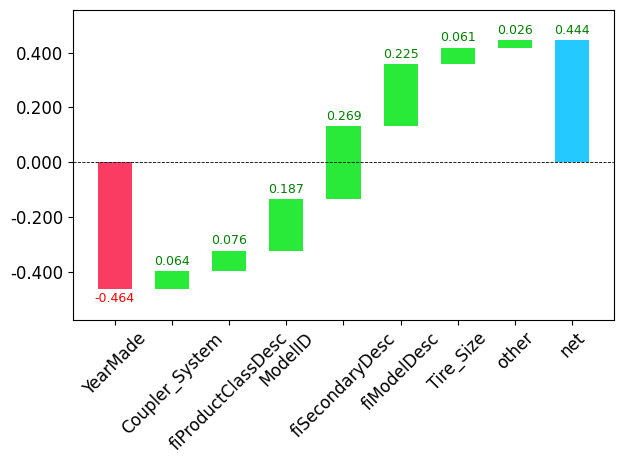

In [ ]:
# note -- thhese are slightly different columns than the book's plot -- not sure why. Maybe randomness somewhere?
waterfall(
  valid_xs_final.columns, contributions[0], threshold=0.08,
  rotation_value=45,formatting='{:,.3f}'
);

### Finding Out-of-Domain Data
- Sometimes it is hard to know whether your test set is distributed in the same way as your training data, or, if it is different, what columns reflect that difference. There's actually an easy way to figure this out, which is to use a random forest!
- But in this case we don't use the random forest to predict our actual dependent variable. Instead, we try to predict whether a row is in the validation set or the training set. To see this in action, let's combine our training and validation sets together, create a dependent variable that represents which dataset each row comes from, build a random forest using that data, and get its feature importance

#### Model predicting whether a row is in the trianing / validation set

In [ ]:
# create new dataset (y = whether or not a row is in the validation set)
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

In [ ]:
# random forest of this data
m = rf(df_dom, is_valid)

In [ ]:
# feature importance
rf_feat_importance(m, df_dom)[:6]

# This shows that there are three columns that differ significantly between the training and validation sets: saleElapsed, SalesID, and MachineID.
# It's fairly obvious why this is the case for saleElapsed: it's the number of days between the start of the dataset and each row, so it directly encodes the date.
# The difference in SalesID suggests that identifiers for auction sales might increment over time.
# MachineID suggests something similar might be happening for individual items sold in those auctions

,cols,imp
5,saleElapsed,0.805110
10,SalesID,0.154258
12,MachineID,0.038218
0,YearMade,0.001265
7,Enclosure,0.000413
1,ProductSize,0.000193


### See the effect of removing each of the columns that are high in importance on the rmse of the (original) model

In [ ]:
# remind ourselves of the orignal model rmse
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

orig 0.24717


In [ ]:
# remove each column
for c in ('SalesID','saleElapsed','MachineID'):
  m = rf(xs_final.drop(c,axis=1), y)
  print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

SalesID 0.24405
saleElapsed 0.249937
MachineID 0.243894


In [ ]:
# remove salesid and machineid
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

# Removing these variables has slightly improved the model's accuracy;
# but more importantly, it should make it more resilient over time, and easier to maintain and understand.
# We recommend that for all datasets you try building a model where your dependent variable is is_valid, like we did here. It can often uncover subtle domain shift issues that you may otherwise miss.

0.242173

## Model 4

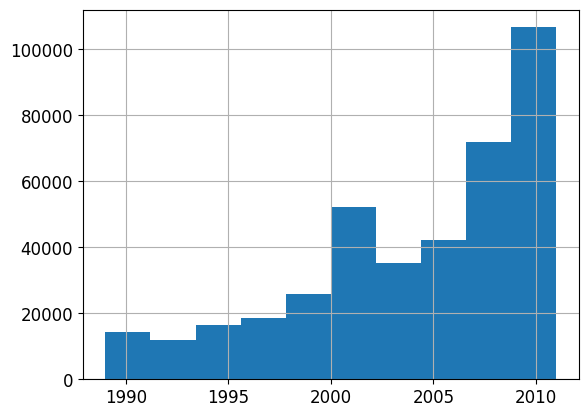

In [ ]:
# try modeling only on recent years because old relationships might not be valid anymore
xs['saleYear'].hist();

In [ ]:
# filter the data
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [ ]:
# evaluate -- it seems okay
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.176275, 0.243111)

# Neural Network
Use NN instead of tree models

NN needs normalization, whereas RF do not!

## Data
- Entity embeddings: reduces memory usage and speeds up neural networks compared with one-hot encoding, but more importantly by mapping similar values close to each other in the embedding space it reveals the intrinsic properties of the categorical variables... [It] is especially useful for datasets with lots of high cardinality features, where other methods tend to overfit. The embedding transforms the categorical variables into inputs that are both continuous and meaningful
- An embedding layer is exactly equivalent to placing an ordinary linear layer (aka dense layer) after every one-hot-encoded input layer
- When we provide the model fundamentally categorical data about discrete entities, the model learns an embedding for these entities that defines a continuous notion of distance between them Because the embedding distance was learned based on real patterns in the data, that distance tends to match up with our intuitions. In addition, it is valuable in its own right that embeddings are continuous, because models are better at understanding continuous variables.
- Another benefit is that we can combine our continuous embedding values with truly continuous input data in a straightforward manner: we just concatenate the variables, and feed the concatenation into our first dense layer. In other words, the raw categorical data is transformed by an embedding layer before it interacts with the raw continuous input data.

In [ ]:
# repeat same data setup
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

# create ordinal categories for product size
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

# take the log of the DV
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

# remove unwanted columns (specified above)
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [ ]:
# split continuous and categorical columns
# and create embeddings of categorical columns
# max card = maximum cardinality of embeddings (number of categories). Try to stay < 10k
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

print(cont_nn) # continuous
df_nn_final[cat_nn].nunique() # categorical -- each col's number of unique values are a column in the embedding matrix

['saleElapsed']


YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Enclosure                6
Hydraulics_Flow          3
fiModelDesc           5059
fiModelDescriptor      140
ProductGroup             6
Hydraulics              12
Drive_System             4
Tire_Size               17
dtype: int64

In [ ]:
# remove one of the categorical variables with high cardinality
cat_nn.remove('fiModelDescriptor')

In [ ]:
# make tabularpandas
# be sure to normalize!!!!!
procs_nn = [Categorify, FillMissing, Normalize]

to_nn = TabularPandas(
  df_nn_final, procs_nn, cat_nn, cont_nn,
  splits=splits, y_names=dep_var
)

In [ ]:
# dataloaders
# tabular models don't take up that much storage so we can make batch size bigger
dls = to_nn.dataloaders(1024)

## Model
- In fastai, a tabular model is simply a model that takes columns of continuous or categorical data, and predicts a category (a classification model) or a continuous value (a regression model). Categorical independent variables are passed through an embedding, and concatenated, as we saw in the neural net we used for collaborative filtering, and then continuous variables are concatenated as well.
- By default, for tabular data fastai creates a neural network with two hidden layers, with 200 and 100 activations, respectively. Good for small datasets.

In [ ]:
# look at range of dv
# because it is a good idea to set y_range for regression models
y = to_nn.train.y
y.min(),y.max()

(8.465899, 11.863583)

In [ ]:
# create learner
learn = tabular_learner(
  dls,
  y_range=(8,12), # same as y range above
  layers=[500,250], # NN has two hidden layers: first layer has 500 activations, second has 250 activations
  n_out=1,
  loss_func=F.mse_loss
)

# save
learn.save('nn')

Path('models/nn.pth')

In [ ]:
# look at tabular learner
  # first calls get_emb_sz to get the embedding size for categorical cols
  # creates tabular model and passes it to tabular learner (same as usual learner but a specified predict function)
tabular_learner??

In [ ]:
# look at tabular model
  # n_cont = number of continuous variables
TabularModel??

SuggestedLRs(valley=0.00013182566908653826)

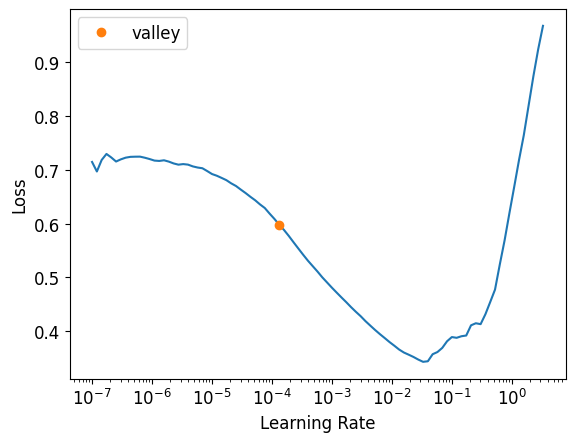

In [ ]:
# find learning rate
learn.lr_find()

In [ ]:
# fit one cycle for a few epochs
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.064193,0.067939,00:05
1,0.053585,0.059162,00:05
2,0.048144,0.059887,00:05
3,0.043122,0.059997,00:05
4,0.039976,0.055130,00:05


In [ ]:
# find rmse (since that's what we used earlier with the random forest)
nn_preds, nn_targs = learn.get_preds()
r_mse(nn_preds,nn_targs)

0.234797

# Ensembling
Combine preds from RF and NN

In [ ]:
# nn preds -- will need to convert to array (from tensor)
nn_preds, nn_targs = learn.get_preds()

# rf preds
rf_preds = m.predict(valid_xs_time)

# ensemble preds
ens_preds = (to_np(nn_preds.squeeze()) + rf_preds) / 2

In [ ]:
# rmse of ensemble preds
r_mse(ens_preds, valid_y)

0.230521

# Side Notes

**Embeddings**
- Using (categorical) embeddings obtained from a trained neural network boost the performance of all tested machine learning methods (KNN, RF, XGB, NN) considerably when used as the input features instead of the original (categorical) columns
- This is a really important result, because it shows that you can get much of the performance improvement of a neural network without actually having to use a neural network at inference time. You could just use an embedding, which is literally just an array lookup, along with a small decision tree ensemble.
- These embeddings need not even be necessarily learned separately for each model or task in an organization. Instead, once a set of embeddings are learned for some column for some task, they could be stored in a central place, and reused across multiple models. In fact, we know from private communication with other practitioners at large companies that this is already happening in many places.

**Summary**
- Random forests are the easiest to train, because they are extremely resilient to hyperparameter choices and require very little preprocessing. They are very fast to train, and should not overfit if you have enough trees. But they can be a little less accurate, especially if extrapolation is required, such as predicting future time periods.
- Gradient boosting machines in theory are just as fast to train as random forests, but in practice you will have to try lots of different hyperparameters. They can overfit, but they are often a little more accurate than random forests.
- Neural networks take the longest time to train, and require extra preprocessing, such as normalization; this normalization needs to be used at inference time as well. They can provide great results and extrapolate well, but only if you are careful with your hyperparameters and take care to avoid overfitting.

- We suggest starting your analysis with a random forest. This will give you a strong baseline, and you can be confident that it's a reasonable starting point. You can then use that model for feature selection and partial dependence analysis, to get a better understanding of your data.
- From that foundation, you can try neural nets and GBMs, and if they give you significantly better results on your validation set in a reasonable amount of time, you can use them. If decision tree ensembles are working well for you, try adding the embeddings for the categorical variables to the data, and see if that helps your decision trees learn better.